In [68]:
from context_analysis.load import load_behaviour, load_traces, load_mice, load_cells
from context_analysis.reshape import split_by_group, split_by_mouse
from context_analysis.resample import temporally_align_onep_behaviour



from neurobox.long_transforms import pivot
from neurobox.compose import Pipeline
from neurobox.wide_transforms import resample
from neurobox.generics import assign_col, select_cols, filter_rows, set_index, drop_cols

from context_analysis.wide_transforms import subset_neurons, align_to_block

import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

In [2]:
session_name = "day4-test1"
traces_test1 = load_traces(experiment="pfc", session_names=[session_name])
behaviour_test1 = load_behaviour(experiment="pfc", session_names=[session_name])

In [3]:
neuron_pipe = Pipeline([
    (pivot, dict(neuron_col="cell_id")),

#     (subset_neurons, dict(group = "Experimental"))
    #     (resample, dict(new_interval="1s")),
])

neuron_data = neuron_pipe.transform(traces_test1)

In [144]:
behaviour_test1

,frame,left_ear_x,left_ear_y,right_ear_x,right_ear_y,tail_x,tail_y,motion,freeze_status,mouse,session_name,group,cohort
0,0,254.354706,248.477295,241.858276,257.357483,223.790268,215.365906,NaN,0.0,B51618,day4-test1,Experimental,2
1,1,257.460388,252.679306,243.850372,262.319336,226.619415,218.165695,3.315097,0.0,B51618,day4-test1,Experimental,2
2,2,260.358948,257.003174,247.955368,265.364471,228.995071,222.695953,3.546412,0.0,B51618,day4-test1,Experimental,2
3,3,262.142395,259.946381,250.704712,269.540039,229.349548,224.919556,2.371607,0.0,B51618,day4-test1,Experimental,2
4,4,264.063721,261.937225,252.473221,270.934906,231.327896,229.001709,2.189341,0.0,B51618,day4-test1,Experimental,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
275482,21588,292.334320,38.247334,294.418182,54.064518,252.397568,67.084244,1.308418,0.0,B58217,day4-test1,No Shock,4
275483,21589,292.990814,35.837521,296.271484,51.938679,252.360229,64.904755,1.543713,0.0,B58217,day4-test1,No Shock,4
275484,21590,299.260254,37.158752,299.210571,50.488647,254.290787,60.873032,2.990345,0.0,B58217,day4-test1,No Shock,4
275485,21591,298.251068,36.001339,299.525757,49.155708,256.411469,60.326733,1.080284,0.0,B58217,day4-test1,No Shock,4


In [7]:
behaviour_pipe = Pipeline([
    (assign_col, dict(col_name="time", func=lambda x: x.frame.divide(30))),
    (select_cols, dict(cols=["session_name", "mouse", "time", "motion", "freeze_status"])),
    (filter_rows, dict(condition=lambda x: x.mouse=="B51618"))
])
behaviour_pipe.transform(behaviour_test1)

,session_name,mouse,time,motion,freeze_status
0,day4-test1,B51618,0.000000,NaN,0.0
1,day4-test1,B51618,0.033333,3.315097,0.0
2,day4-test1,B51618,0.066667,3.546412,0.0
3,day4-test1,B51618,0.100000,2.371607,0.0
4,day4-test1,B51618,0.133333,2.189341,0.0
...,...,...,...,...,...
21586,day4-test1,B51618,719.533333,0.109528,0.0
21587,day4-test1,B51618,719.566667,0.060504,0.0
21588,day4-test1,B51618,719.600000,0.137385,0.0
21589,day4-test1,B51618,719.633333,0.303078,0.0


In [22]:
mice = behaviour_test1.mouse.unique()
# subset_neurons
# mice
# align_to_block
drop_cols

<function neurobox.generics.drop_cols(df: pandas.core.frame.DataFrame, cols: List[str]) -> pandas.core.frame.DataFrame>

In [249]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import r2_score

def make_neuron_pipe(mouse, new_interval="1s"):
    return Pipeline([
    (filter_rows, dict(condition=lambda x: x.mouse == mouse)),
    (pivot, dict(neuron_col="cell_id")),
    (resample, dict(new_interval=new_interval)),
])


def make_behaviour_pipe(mouse, new_interval="1s"):
    return Pipeline([
        (filter_rows, dict(condition=lambda x: x.mouse == mouse)),
        (assign_col, dict(col_name="time", func=lambda x: x.frame.divide(30))),
        (set_index, dict(col="time")),
        (resample, dict(new_interval=new_interval)),
        (align_to_block, dict(session_name="day4-test1")),
        (select_cols, dict(cols=["motion", "freeze_status", "block"])),
    ])

def make_equal_length(neurons, behav):
    idx = np.min([neurons.index.max(), behav.index.max()])
    return neurons.loc[lambda x: x.index < idx], behav.loc[lambda x: x.index < idx]
    

def fit_lasso(col, X, mod_fac):
    out = {}
    y = col.values.reshape(-1, 1)
#     X, y = make_equal_length(X.values, y)
    model = mod_fac()
    model.fit(X, y)
    out["intercept_coef"] = model.intercept_[0]
    out["motion_coef"] = model.coef_[0][0]
    out["freeze_coef"] = model.coef_[0][1]
    out["context_coef"] = model.coef_[0][2]
    out["r2"] = r2_score(y, model.predict(X),)
    return pd.Series(out)

In [250]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.base import clone

ct = make_column_transformer(
    (StandardScaler(), ["motion"]),
    (OneHotEncoder(drop="first"), ["freeze_status", "block"])
)

In [251]:
from sklearn.linear_model import Ridge

def mod_maker():
    return Ridge(0.1)

In [252]:
mice

array(['B51618', 'B51619', 'B51620', 'B51621', 'B51622', 'B51628',
       'B51629', 'B51630', 'B51631', 'B57677', 'B58215', 'B58216',
       'B58217'], dtype=object)

In [253]:
mice = behaviour_test1.mouse.unique()
from scipy.stats import zscore
out = []

for mouse in mice:
    pipe = make_neuron_pipe(mouse=mouse)
    pipe2 = make_behaviour_pipe(mouse=mouse)
    neuronal_data = pipe.transform(traces_test1)
    behaviour_data = pipe2.transform(behaviour_test1)
    if len(neuronal_data) < 700:
        print(mouse)
        continue
    neuronal_data, behaviour_data = make_equal_length(neuronal_data, behaviour_data)
#     neuronal_data = neuronal_data.apply(zscore)
    X = clone(ct).fit_transform(behaviour_data)
    res = neuronal_data.apply(fit_lasso, X=X, mod_fac=mod_maker).transpose()
    res = res.assign(mouse=mouse)
    out.append(res)

B51619


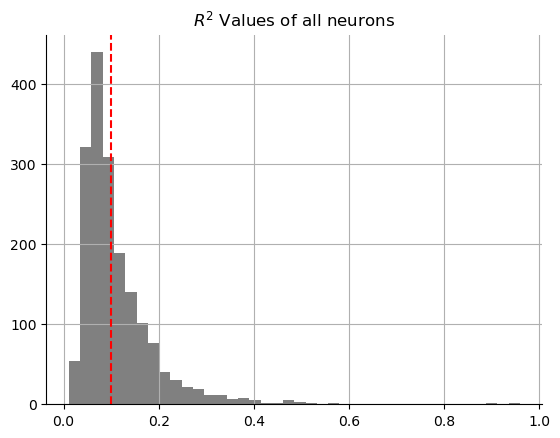

In [254]:
res = pd.concat(out)
# res
ax = res.r2.hist(bins=40, color="gray")
plt.axvline(0.1, color="red", linestyle="dashed")
plt.title(r"$R^2$ Values of all neurons")
sns.despine()
plt.show()

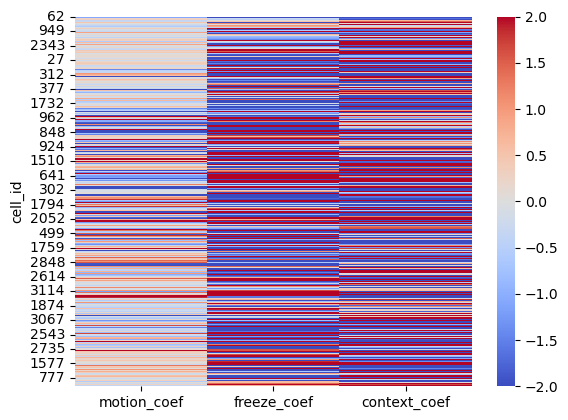

In [255]:
responsers = res.loc[lambda x: x.r2 > 0.1]

sns.heatmap(responsers.iloc[:, 1:-2], cmap="coolwarm", vmin=-2, vmax=2)
plt.show()

In [256]:
neurons = load_cells("pfc").assign(cell_id = lambda x: x.cell_id.astype(str))[["group", "cell_id"]]

In [257]:
res2 = res.reset_index().merge(neurons)

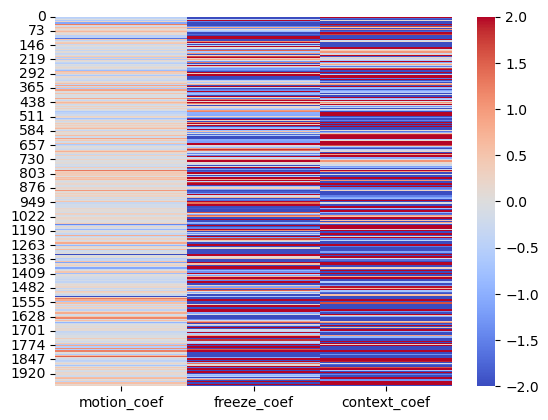

In [258]:
dfp = res2.loc[lambda x: x.group == "Experimental"]

sns.heatmap(dfp[["motion_coef", "freeze_coef", "context_coef"]], cmap="coolwarm", vmin=-2, vmax=2)
plt.show()

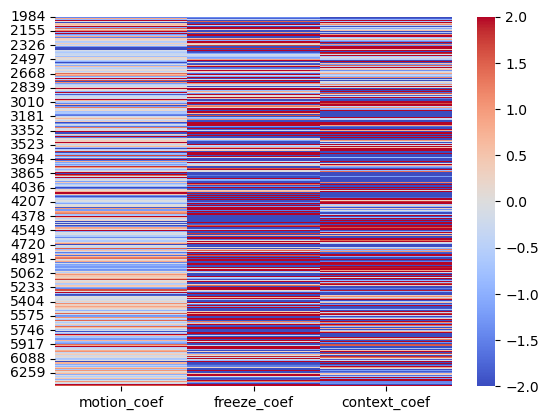

In [259]:
dfp = res2.loc[lambda x: x.group == "One Context"]

sns.heatmap(dfp[["motion_coef", "freeze_coef", "context_coef"]], cmap="coolwarm", vmin=-2, vmax=2)
plt.show()

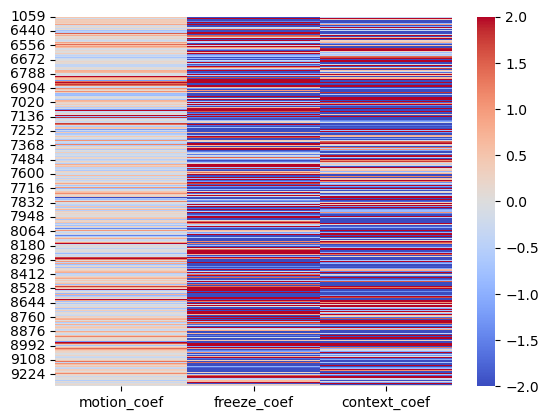

In [260]:
dfp = res2.loc[lambda x: x.group == "No Shock"]

sns.heatmap(dfp[["motion_coef", "freeze_coef", "context_coef"]], cmap="coolwarm", vmin=-2, vmax=2)
plt.show()

In [261]:
from sklearn.cluster import KMeans

In [262]:
X = res[["motion_coef", "freeze_coef", "context_coef"]]

C:\Users\roryl\.conda\envs\cyl\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


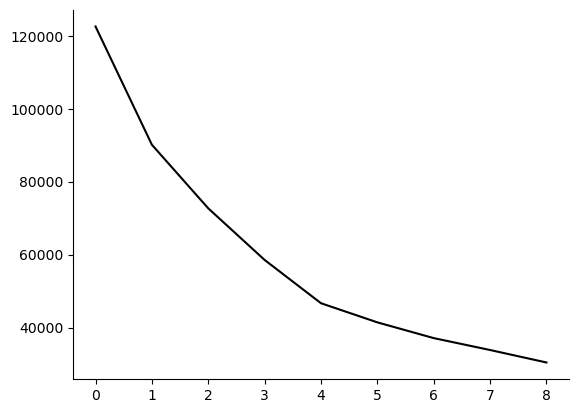

In [263]:
error = []
for i in range(1, 10):
    mod = KMeans(i)
    mod.fit(X)
    error.append(mod.inertia_)
plt.plot(error, color="black")
sns.despine()
plt.show()

In [274]:
mod = KMeans(4).fit(X)
idx = mod.predict(X)

In [275]:
res["cluster"] = idx

In [276]:
res

,intercept_coef,motion_coef,freeze_coef,context_coef,r2,mouse,cluster,neuron type
cell_id,,,,,,,,
11,19.577486,-0.493098,-3.340369,10.638094,0.052576,B51618,2,NaN
0,10.071886,-0.384606,-2.138585,-1.758403,0.062774,B51618,3,motion inactive
114,4.934738,-0.052392,-0.375939,-4.820593,0.057383,B51618,1,scary context active
23,9.314722,-0.614986,8.116944,0.145209,0.054701,B51618,0,motion active
62,10.887244,0.248910,-1.497500,-6.725396,0.142852,B51618,1,scary context active
...,...,...,...,...,...,...,...,...
623,2.610171,0.165889,0.402694,-2.638522,0.148818,B58217,3,motion inactive
700,2.236345,0.243182,2.294820,1.680791,0.365365,B58217,3,motion inactive
711,3.929610,-0.031106,-0.068305,0.035674,0.497535,B58217,3,motion inactive


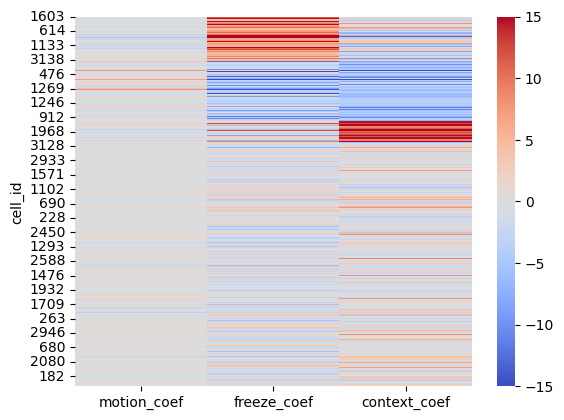

In [297]:
sns.heatmap(res.sort_values("cluster")[["motion_coef", "freeze_coef", "context_coef"]], cmap="coolwarm", vmin=-15, vmax=15)
plt.show()

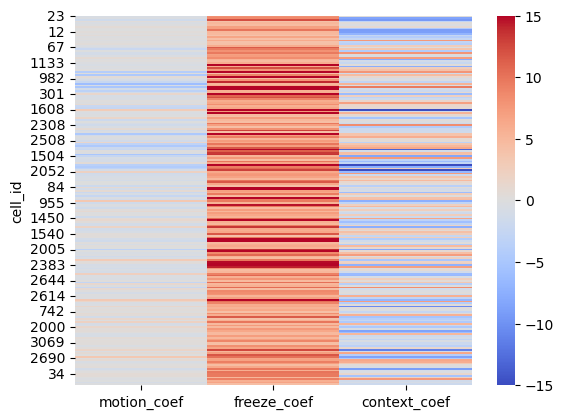

In [296]:
sns.heatmap(res.loc[lambda x: x.cluster == 0][["motion_coef", "freeze_coef", "context_coef"]], cmap="coolwarm", vmin=-15, vmax=15)
plt.show()

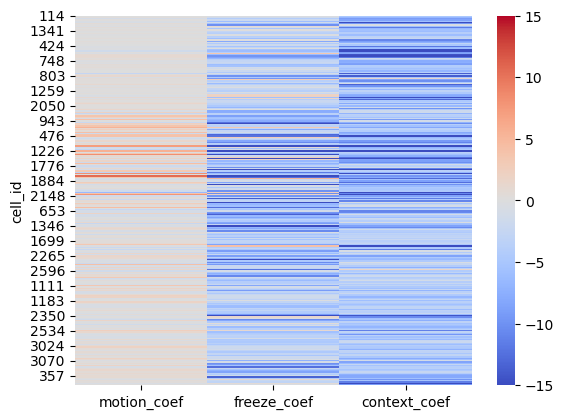

In [295]:
sns.heatmap(res.loc[lambda x: x.cluster == 1][["motion_coef", "freeze_coef", "context_coef"]], cmap="coolwarm", vmin=-15, vmax=15)
plt.show()

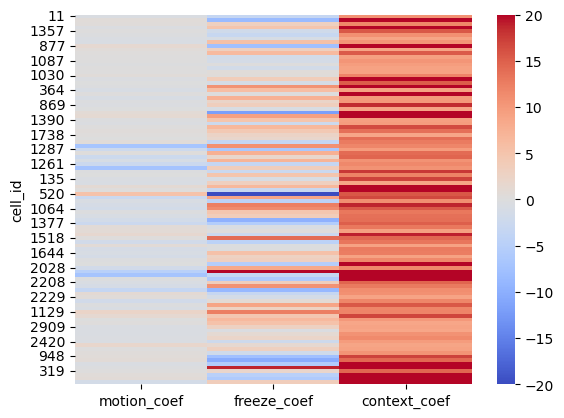

In [293]:
sns.heatmap(res.loc[lambda x: x.cluster == 2][["motion_coef", "freeze_coef", "context_coef"]], cmap="coolwarm", vmin=-20, vmax=20)
plt.show()

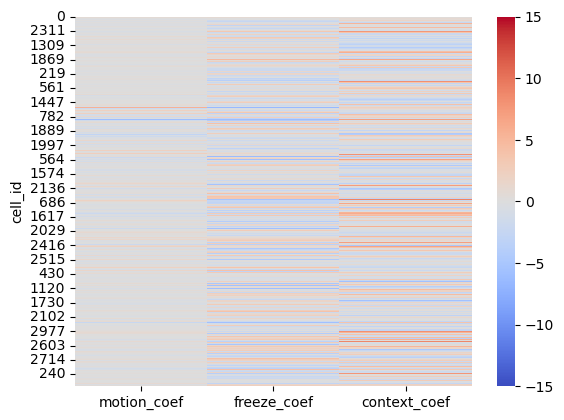

In [298]:
sns.heatmap(res.loc[lambda x: x.cluster == 3][["motion_coef", "freeze_coef", "context_coef"]], cmap="coolwarm", vmin=-15, vmax=15)
plt.show()

In [285]:
res["neuron type"] = res["cluster"].map({0: "motion active", 1: "scary context active", 2: "motion inactive", 4: "mixed"})

In [286]:
res.reset_index().merge(neurons.drop_duplicates()).groupby("group")["neuron type"].value_counts()

group         neuron type         
Experimental  scary context active     65
              motion inactive          30
              motion active            28
No Shock      scary context active     93
              motion active            52
              motion inactive          25
One Context   scary context active    138
              motion active           134
              motion inactive          45
Name: neuron type, dtype: int64

In [237]:
res

,intercept_coef,motion_coef,freeze_coef,context_coef,r2,mouse,cluster
cell_id,,,,,,,
11,20.105923,-0.460257,-0.0,0.000000,0.028563,B51618,0
0,12.099339,-0.692408,-0.0,-0.000000,0.034639,B51618,0
114,5.490901,-0.109954,-0.0,-0.000000,0.038823,B51618,0
23,10.218308,-0.608095,0.0,-0.000000,0.012815,B51618,0
62,9.059759,0.409489,0.0,-0.000000,0.072659,B51618,0
...,...,...,...,...,...,...,...
623,2.621565,0.000000,0.0,-0.000000,0.025200,B58217,0
700,2.240225,0.239850,0.0,0.000000,0.343501,B58217,0
711,4.163620,-0.000000,0.0,-0.000000,0.410015,B58217,0


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics